In [10]:
import pandas as pd
import glob
import re
import gensim
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
! pip install pyLDAvis
import pyLDAvis.gensim
import numpy as np
from gensim.models import CoherenceModel
import nltk
from sklearn.pipeline import Pipeline
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
all_files = [f for f in glob.glob("database/*.tsv") if re.match(r'database/database_\d+-\d+-\d+\.tsv',f)]
lst=[pd.read_table(f,header=None) for f in all_files]
frame = pd.concat(lst, ignore_index=True)
frame

,0,1,2,3,4,5,6,7,8,9
0,"11/10/2020, 17:05:36","11/10/2020, 20:27:07",FinSME,Hopin Raises $125M in Series B Funding,https://www.finsmes.com/2020/11/hopin-raises-1...,"Hopin, a London, UK-based virtual events provi...",(Funding),Not Computed,"('Hopin Raises', 'ORG')('$125M', 'MONEY')",-
1,"11/10/2020, 17:05:36","11/10/2020, 20:06:04",FinSME,Tailscale Raises $12M in Series A Funding,https://www.finsmes.com/2020/11/tailscale-rais...,"Tailscale, a Toronto, Canada-based corporate V...",(Funding),Not Computed,"('Tailscale Raises', 'ORG')",-
2,"11/10/2020, 17:05:36","11/10/2020, 19:53:53",FinSME,TA Associates and TPG To Acquire Planview from...,https://www.finsmes.com/2020/11/ta-associates-...,TPG Capital and TA Associates are to acquire P...,(M&A),Not Computed,"('TA Associates', 'ORG')('Thoma Bravo', 'ORG')...",-
3,"11/10/2020, 17:05:36","11/10/2020, 16:46:46",FinSME,Buoy Health Raises $37.5M in Series C Funding,https://www.finsmes.com/2020/11/buoy-health-ra...,"Buoy Health, a Boston, MA-based AI-powered hea...",(Funding),Not Computed,"('Buoy Health Raises', 'ORG')('37.5', 'MONEY')",-
4,"11/10/2020, 17:05:36","11/10/2020, 16:24:52",FinSME,Carbon Health Secures $100M in Series C Funding,https://www.finsmes.com/2020/11/carbon-health-...,"Carbon Health, a San Francisco, CA-based techn...",(Funding /Possible_Funding),Not Computed,"('Carbon Health Secures', 'ORG')('100', 'MONEY')",-
...,...,...,...,...,...,...,...,...,...,...
10653,"11/20/2020, 16:34:34","11/20/2020, 00:00:00",Crunchbase News-Public,These Tech Companies Have Added Over $90B In V...,https://news.crunchbase.com/news/these-tech-co...,Wish revealed in its IPO filing that it is qui...,(No Keywords detect),(IPOs),NaN,-
10654,"11/20/2020, 16:34:34","11/09/2020, 00:00:00",Crunchbase News-Public,Monthly Funding Recap October 2020: 14 New Uni...,https://news.crunchbase.com/news/monthly-fundi...,"Global venture funding in October 2020, the fi...",(Funding),Not Computed,"('Monthly', 'DATE')('October 2020', 'DATE')('1...",-
10655,"11/20/2020, 16:34:34","11/05/2020, 00:00:00",Crunchbase News-Public,Airbnb Lines Up Public IPO Filing For 2020 Debut,https://news.crunchbase.com/news/airbnb-ipo-fi...,Airbnb reportedly plans to set an IPO price ra...,(IPOs),Not Computed,"('Airbnb', 'GPE')('2020', 'DATE')",-
10656,"11/20/2020, 16:34:34","10/21/2020, 00:00:00",Crunchbase News-Public,ThredUp Spins Up IPO Plans,https://news.crunchbase.com/news/thredup-ipo/,Online used clothing retailer ThredUp said it'...,(IPOs),Not Computed,NaN,-


In [5]:
# WORK ON NOISE NEWS A LITTLE
# noise = frame[(frame.iloc[:,6]=='(No Keywords detect)')].iloc[:,0:6]
# noise.columns=['time_scraped','time_published','source','Title','Link','text']
# noise = noise.drop_duplicates(subset=['Title'])
# noise.to_csv('database/train_data/noise.csv')

# hand label some news
noise = pd.read_csv("database/train_data/noise.csv")
funding = pd.read_csv("database/train_data/funding.csv")
MA = pd.read_csv("database/train_data/M&A.csv")

MA['category'] = 'M&A'
funding['category'] = 'Funding'
noise['category'] = 'Non-Deal'
# Combine three data sources into a single dataframe
news_df = pd.concat([funding,MA,noise[['title','link','category']]],ignore_index=True)

In [6]:
#Text Preprocressing
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
    return norm_papers

tokenized_docs = normalize_corpus(news_df['title'])
print(len(tokenized_docs))

722


In [7]:
#Create Bigram Corpus
bigram = Phrases(tokenized_docs, min_count=3, threshold=5)
bigram_texts = [bigram[line] for line in tokenized_docs]
id2word = Dictionary(bigram_texts)
print('Total Vocabulary Size (Before):', len(id2word))

Total Vocabulary Size (Before): 3008


In [8]:
#convert to categories
corpus = [id2word.doc2bow(line) for line in bigram_texts]
corpus

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)],
 [(13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)],
 [(20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(12, 1), (29, 1), (30, 1), (31, 1)],
 [(28, 1), (32, 1), (33, 1), (34, 1), (35, 1)],
 [(7, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
 [(36, 1),
  (37, 1),
  (38, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1)],
 [(44, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1)],
 [(16, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1)],
 [(12, 1), (68, 1), (69, 1), (70, 1)],
 [(28, 1), (69, 1), (71, 1), (72, 1), (73, 1), (74, 1)],
 [(41, 1),
  (42, 1),
  (46, 1),
  (49, 1),
  (57, 1),
  (61, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79,

2 0.43415093472779054
3 0.4250072068448995
4 0.4416521505578711
5 0.45898930720954756
6 0.4624819352349307
7 0.44143142389078455
8 0.45914019466507316


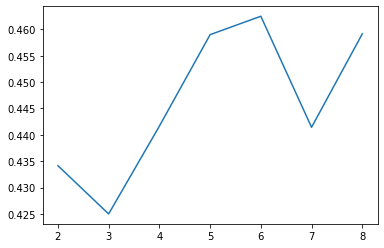

In [12]:
def compute_coherence_values(corpus, id2word, k):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=len(bigram_texts),
                                           passes=10,
                                           per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_texts,
                                         dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()


cv_scores = []
for k in range(2, 9):
    score = compute_coherence_values(corpus=corpus, id2word=id2word, k=k)
    cv_scores.append(score)
    print(k, score)
import seaborn as sns
import matplotlib.pyplot as plt
optimal_k = np.array(cv_scores).argmax() + 2
sns.lineplot(x=np.arange(2, 9), y=cv_scores)
plt.show()

In [16]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         random_state=100,
                         num_topics=3,
                         passes=10,
                         chunksize=len(bigram_texts),
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.008*"new" + 0.007*"company" + 0.006*"based" + 0.006*"acquire" + 0.006*"acquires" + 0.006*"capital" + 0.005*"business" + 0.004*"acquisition" + 0.004*"venture" + 0.004*"group"'),
 (1,
  '0.003*"million" + 0.003*"funding" + 0.002*"capital" + 0.002*"group" + 0.002*"de" + 0.002*"lead" + 0.002*"financial" + 0.002*"secures" + 0.002*"firm" + 0.002*"acquired"'),
 (2,
  '0.001*"la" + 0.001*"space" + 0.001*"airport" + 0.001*"global" + 0.001*"billion" + 0.001*"galardonada" + 0.001*"vuse" + 0.001*"session" + 0.001*"energy" + 0.001*"tc"')]

In [17]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         random_state=100,
                         num_topics=6,
                         passes=30,
                         chunksize=len(bigram_texts),
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

lda_model.print_topics()

[(0,
  '0.011*"new" + 0.010*"acquire" + 0.008*"based" + 0.008*"company" + 0.007*"capital" + 0.007*"acquires" + 0.006*"firm" + 0.006*"technology" + 0.006*"raise" + 0.006*"business"'),
 (1,
  '0.007*"new" + 0.007*"million" + 0.007*"acquires" + 0.007*"funding" + 0.006*"group" + 0.006*"company" + 0.005*"capital" + 0.005*"based" + 0.005*"health" + 0.004*"platform"'),
 (2,
  '0.008*"capital" + 0.007*"company" + 0.004*"billion" + 0.004*"energy" + 0.004*"million" + 0.004*"announces" + 0.004*"global" + 0.004*"spac" + 0.003*"venture" + 0.003*"la"'),
 (3,
  '0.006*"largest" + 0.005*"acquires" + 0.004*"new" + 0.004*"one" + 0.003*"affirm" + 0.003*"bring" + 0.003*"usa" + 0.003*"schedule" + 0.003*"columbus" + 0.003*"first"'),
 (4,
  '0.008*"venture" + 0.006*"based" + 0.005*"announces" + 0.005*"market" + 0.005*"de" + 0.004*"et" + 0.004*"building" + 0.004*"per" + 0.004*"read" + 0.003*"company"'),
 (5,
  '0.006*"wi_fi" + 0.005*"development" + 0.004*"air" + 0.004*"spring" + 0.004*"spac" + 0.003*"opportun

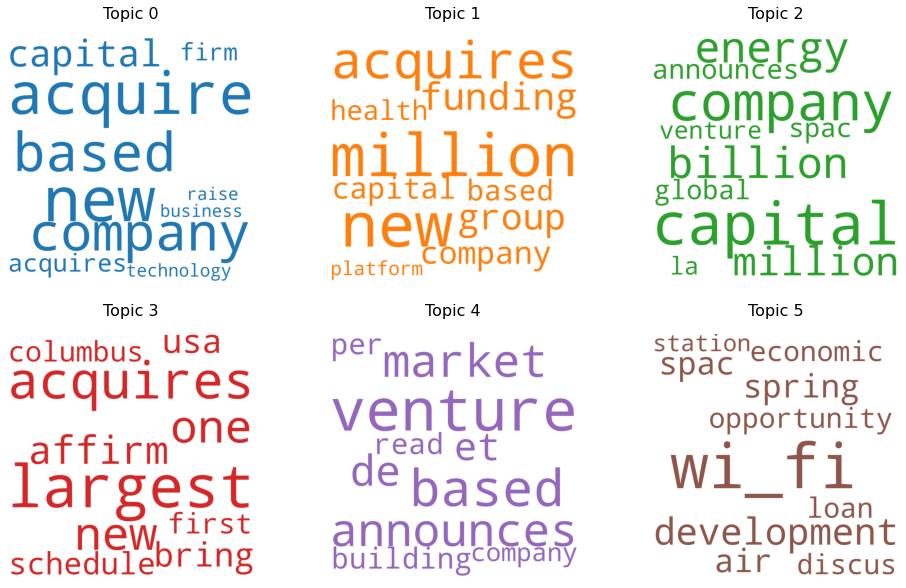

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1200,
                  height=1200,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16), y=1.05)
    plt.gca().axis('off')


plt.subplots_adjust(wspace=.3, hspace=.2)
plt.axis('off')
plt.margins(x=0, y=0)
#plt.tight_layout()
plt.show()

In [19]:
plt.style.use('fivethirtyeight')
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140402 -0.029507       1        1  54.021997
1     -0.059734 -0.118909       2        1  18.930280
2     -0.017448  0.058664       3        1  10.765058
4     -0.023825  0.042757       4        1   8.297583
3     -0.021620  0.021446       5        1   4.923313
5     -0.017775  0.025549       6        1   3.061769, topic_info=             Term       Freq      Total Category  logprob  loglift
91        venture  26.000000  26.000000  Default  30.0000  30.0000
406   development   9.000000   9.000000  Default  29.0000  29.0000
34      announces  20.000000  20.000000  Default  28.0000  28.0000
684      acquires  36.000000  36.000000  Default  27.0000  27.0000
261        market  14.000000  14.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
334       billion   0.438231  18.443755   Topic6  -6.1460  -0.2536
524      business   0.401820  28.795568   Topic6  -6.2327  -0.7858
926        street   0.324813   4.048530   Topic6  -6.4455   0.9633
2013           hq   0.324444   2.085304   Topic6  -6.4466   1.6256
93           five   0.324403   1.729349   Topic6  -6.4468   1.8127

[377 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
546       1  0.843685        1m
681       1  0.907932   acquire
681       3  0.051882   acquire
681       4  0.025941   acquire
848       1  0.847802  acquired
...     ...       ...       ...
796       1  0.457224     world
796       2  0.304816     world
796       4  0.152408     world
796       5  0.152408     world
1509      4  0.884893    yonhap

[461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4, 6])

In [21]:
x = lda_model.show_topics(num_words=50)

twords = {}
for topic, word in x:
    twords[topic] = re.findall(r'\"(.*?)\"', word)

twords_df = pd.DataFrame(twords)
twords_df.columns = ['Topic ' + str(i) for i in range(optimal_k)]
twords_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,new,new,capital,largest,venture,wi_fi
1,acquire,million,company,acquires,based,development
2,based,acquires,billion,new,announces,air
3,company,funding,energy,one,market,spring
4,capital,group,million,affirm,de,spac
5,acquires,company,announces,bring,et,opportunity
6,firm,capital,global,usa,building,economic
7,technology,based,spac,schedule,per,loan
8,raise,health,venture,columbus,read,discus
9,business,platform,la,first,company,station


In [22]:
#Build a feature dictionary
features = []
for words in twords.values():
    features.extend(words)
feature_dict = {word:i for i, word in enumerate(set(features))}
len(feature_dict)

227

In [26]:
#Build Text Classification Model
def featurize(texts, bigram_phrase, feature_dict):
    tokenized_docs = normalize_corpus(texts)
    bigram_texts = [bigram_phrase[line] for line in tokenized_docs]

    data = np.zeros((len(texts), len(feature_dict)))

    for i, text in enumerate(bigram_texts):
        for word in text:
            if word in feature_dict.keys():
                word_idx = feature_dict[word]
                data[i, word_idx] = 1
    return data

In [28]:
data = featurize(news_df['title'], bigram, feature_dict)
X = data
Y = news_df['category']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
pipeline = Pipeline([('clf', RandomForestClassifier())]) # Use Random Forest to identify topic
model = pipeline.fit(X_train, y_train)
ytest = np.array(y_test)
print(classification_report(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

     Funding       0.96      0.81      0.88        32
         M&A       0.84      0.86      0.85        42
    Non-Deal       0.87      0.92      0.89        71

    accuracy                           0.88       145
   macro avg       0.89      0.86      0.87       145
weighted avg       0.88      0.88      0.88       145



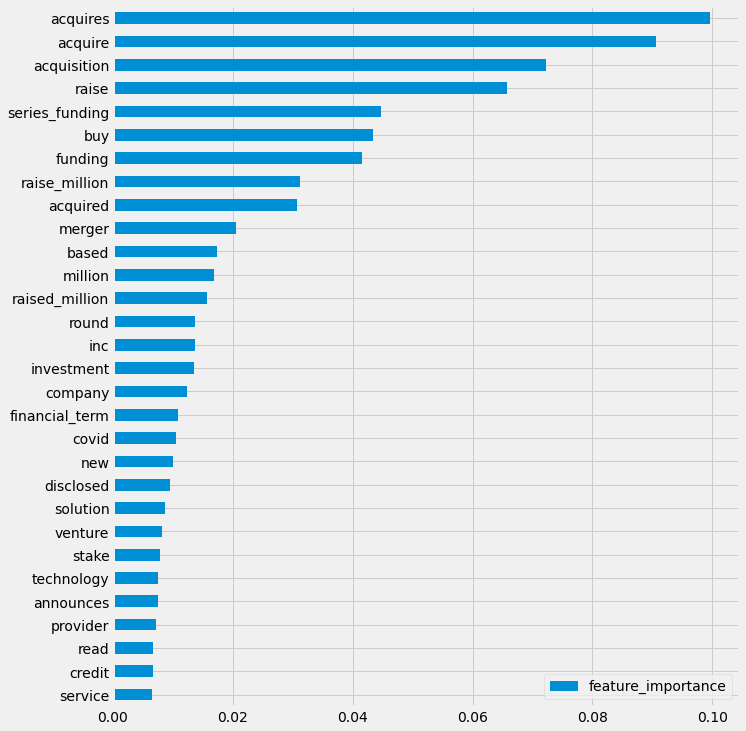

In [30]:
#Feature Importance
all_features = list(feature_dict.keys())
feature_importance = pd.DataFrame(model.steps[0][1].feature_importances_, index=all_features, columns=['feature_importance'])
feature_importance.sort_values('feature_importance').tail(30).plot.barh(figsize=[10,12])
plt.show()

In [31]:
df = frame.iloc[:,0:6]
df.columns = ['time_scraped','time_published','source','title','link','text']
df = df.drop_duplicates(subset=['title'])
df['all'] = df['title'] + ' ' + df['text']
df_new = df[df['all'].apply(lambda x: not isinstance(x, (float, int)))]

df_new['category_pred'] = model.predict(featurize(df_new['all'], bigram, feature_dict))
prob = pd.DataFrame(model.predict_proba(featurize(df_new['all'], bigram, feature_dict)), columns=model.steps[0][1].classes_).round(2)
df_new['Funding_prob'] = prob['Funding']
df_new['MA_prob'] = prob['M&A']
df_new['No_prob'] = prob['Non-Deal']

array(['Funding', 'Funding', 'M&A', ..., 'M&A', 'M&A', 'M&A'],
      dtype=object)

In [36]:
df_new.iloc[:,6:10].head(20)

,all,category_pred,Funding_prob,MA_prob
0,"Hopin Raises $125M in Series B Funding Hopin, ...",Funding,0.67,0.19
1,Tailscale Raises $12M in Series A Funding Tail...,Funding,0.78,0.15
2,TA Associates and TPG To Acquire Planview from...,M&A,0.12,0.80
3,Buoy Health Raises $37.5M in Series C Funding ...,Funding,0.77,0.18
4,Carbon Health Secures $100M in Series C Fundin...,Funding,0.68,0.27
5,Maestro Raises $7.2M in Series A Funding Maest...,Funding,0.68,0.21
6,"Pkware Acquires Dataguise Pkware, a Milwaukee,...",M&A,0.05,0.94
7,Remote Secures $35M in Series A Funding Remote...,Funding,0.75,0.19
8,JumpCloud Raises $75M in Series E Funding Jump...,Funding,0.74,0.21
9,Accenture Launches Project Spotlight Accenture...,Non-Deal,0.41,0.13
